# Corrales et al. (2016), *eLife* - Fig. 1

## Getting started


* Install pytrack-analysis

## Outline

1. [File system operations](#section1)
  1. [Setting up a profile](#section1.1)
  2. [Loading the database](#section1.2)
  3. [Logging](#section1.3)
<br><br>
2. [Data Exploration](#section2)
  1. [Find session for Figure 1C & D](#section2.1)
  2. [Exploring two candidates](#section2.2)
  3. [Identifying the winner](#section2.3)
<br><br>
3. [Data Analysis](#section3)
  1. [Loading raw data and meta data](#section3.1)
  2. [Preprocessing](#section3.2)
  3. [Distance from patch](#section3.3)
  4. [Linear speeds](#section3.4)
  5. [Angular heading & speed](#section3.5)
  6. [Ethogram](#section3.6)
  7. [Visits](#section3.7)
  8. [Loading ethogram data from multiple sessions](#section3.8) 
  9. [Durations of behavioral segments](#section3.9)
<br><br>
4. [Data Visualization](#section4)
  1. [Introduction](#section4.1)
  2. [Data hooks & other helpers](#section4.2)
  3. [Figure 1C](#section4.3)
  4. [Figure 1D](#section4.4)
  5. [Figure 1E](#section4.5)
  6. [Figure 1F](#section4.6)
  7. [Figure 1G](#section4.7)
  8. [Figure 1H](#section4.8)
<br><br>
5. [Closing remarks](#section4)

In [7]:
import sys
print(sys.version)
from pytrack_analysis.profile import *
from pytrack_analysis.database import *
from pytrack_analysis.logger import Logger
import pytrack_analysis.preprocessing as prep
from pytrack_analysis.kinematics import Kinematics
from pytrack_analysis.statistics import Statistics

3.6.0 (v3.6.0:41df79263a11, Dec 23 2016, 07:18:10) [MSC v.1900 32 bit (Intel)]


<a id='section1'></a>
## 1. File system operations

<a id='section1.1'></a>
### A) Setting up a profile

In [8]:
### Setting up a profile

# import os module to interact with filesystem
import os
# get filename of this script
thisscript = "Notebook Fig. 1"
# get profile for project 'Vero eLife 2016' as user 'degoldschmidt'
profile = get_profile('Notebook - Vero eLife 2016', 'degoldschmidt', script=thisscript)
# show the profile
show_profile(profile)

Loaded [PROJECT] Notebook - Vero eLife 2016

$PROJECTS:
- Vero eLife 2016
- Notebook - Vero eLife 2016
$USERS:
- degoldschmidt

Notebook - Vero eLife 2016:
  created: '2017-08-11 11:37:03'
  last active: '2017-08-11 11:40:27'
  systems:

    VERO-PC:
      database: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016/vero_elife_2016.yaml
      log: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing\main.log
      os: Windows_NT
      output: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing
      plot: E:/Dennis/Google Drive/PhD Project/Archive/VERO/vero_elife_2016_processing\plots
      python: 3.6.0 (v3.6.0:41df79263a11, Dec 23 2016, 07:18:10) [MSC v.1900 32 bit
        (Intel)]
      videos: E:/Dennis/Google Drive/PhD Project/Archive/VERO/Example Videos
  users:
  - degoldschmidt
Vero eLife 2016:
  created: '2017-07-14 20:28:00'
  last active: '2017-08-11 11:36:31'
  systems:
    MacBook-Pro-3.local_degoldschmidt:
      da

<a id='section1.2'></a>
### B) Loading the database

Now, we want to load our database. The database class allows us to load file structure 

In [9]:
# get database from file
db = Database(get_db(profile))

STARTING DATA INTEGRITY TEST...
-------------------------------
CHECKING DATABASE...			[O.K.]
CHECKING METAFILES...			[O.K.]
CHECKING DATAFILES...			[O.K.]
CHECKING TIMESTAMPS...			[O.K.]


<a id='section1.3'></a>
### C) Logging

In [10]:
# set up logger for this script
log = Logger(profile, scriptname=thisscript)

<a id='section2'></a>
## 2. Data Exploration

<a id='section2.1'></a>
### A) Find session for Figure 1C & D

First, we need to find which session correspond to the data shown in Fig. 1 C and D. From the original MATLAB scripts, I found that the video file `0003A01R01Cam03.avi` was used for analysis in Fig 1 C-D. The `database` class has a function called `find` to find sessions that match a key-value relation (here: key is `Videofilename` and value is `0003A01R01Cam03.avi`).

<img src="./img/ori-fig1d.png" width="405" height="410">

In [11]:
# Print possible sessions with given video filename 
possible_sessions = db.find('Videofilename=0003A01R01Cam03.avi')
print(possible_sessions)

['CANS_004', 'CANS_005']


<a id='section2.2'></a>
### B) Exploring two candidates

In [12]:
preview_data = []
# Since output gives two possibilities, we want to find out more about both sessions
for session in possible_sessions:
    this_session = db.session(session)
    # preview function gives subsampled raw data 
    preview_data.append(this_session.preview(subsampling=2))

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes=True) 
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("ticks")

In [1]:
def plot_2d(_data):
    fscale = 10
    if len(_data) == 2:
        fig, axes = plt.subplots(1, 2, figsize=(2*fscale,fscale))
    elif len(_data) == 1:
        fig, sax = plt.subplots(1, figsize=(fscale,fscale))
        axes = [sax]
    for i, ax in enumerate(axes):
        data = _data[i]
        ax.plot(data.loc[:,'head_x'], data.loc[:,'head_y'], 'k-', lw=1)
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(possible_sessions[i]+":", fontsize=24, fontweight='bold', loc='left')
    return fig, axes

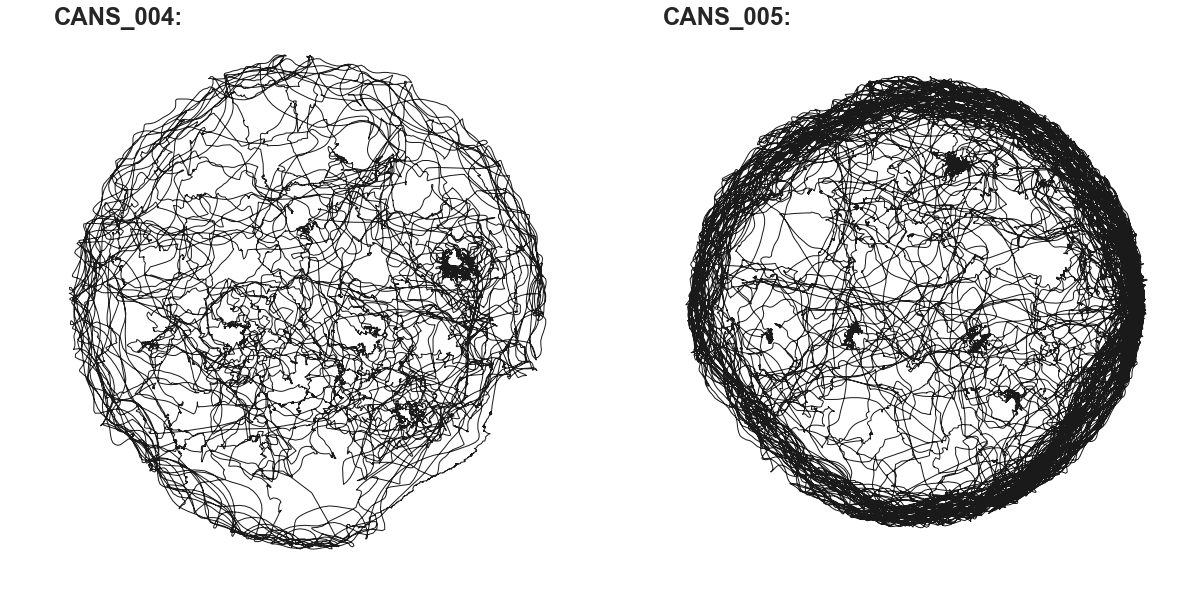

In [15]:
# plot 2d trajectory
fig, axes = plot_2d(preview_data)

In [16]:
def plot_2d_patches(_data, add_numb=[True, False]):
    fig, axes = plot_2d(_data)
    ### add food spots
    # colors (1: orange 2: blue, 3: white)
    patch_color = {1: '#ffc04c', 2: '#4c8bff', 3: '#ffffff'}
    for i, ax in enumerate(axes):
        # food patch positions (x, y)
        patch_positions = db.session(possible_sessions[i]).PatchPositions
        # food patch substrate type (1: yeast, 2: sucrose, 3: center/empty)
        patch_type = db.session(possible_sessions[i]).SubstrateType
        # food patch radius
        patch_radius = db.session(possible_sessions[i]).patch_radius
        # go through all patches
        for j, pos in enumerate(patch_positions):
            # get color for given patch
            c = patch_color[patch_type[j]]
            # define circle at position "pos" with radius "patch_radius"
            circle = plt.Circle(pos, patch_radius, color=c, alpha=0.5, zorder=5)
            # add circle to axis artist (draws the circle)
            ax.add_artist(circle)
            # also add text to circle
            if add_numb[i]:
                ax.text(pos[0],pos[1], str(j), zorder=6, color="#FF2965", fontsize=28, fontweight='bold', clip_on=True)
    return fig, axes

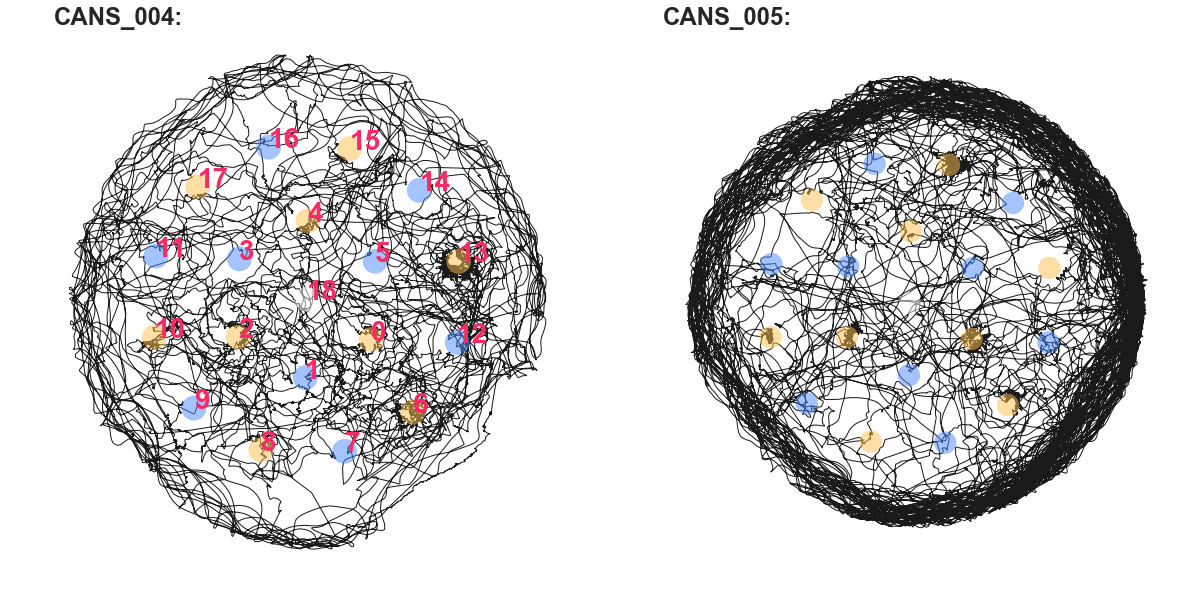

In [17]:
# plot 2d trajectory with color patches
fig, axes = plot_2d_patches(preview_data)

In [18]:
def plot_2d_patches_zoom(_data, _zoom):
    fig, axes = plot_2d_patches(_data)
    zoom = _zoom
    offsetx = 15
    offsety = -18
    for ax in axes:
        ax.set_xlim([-zoom+offsetx, zoom+offsetx])
        ax.set_ylim([-zoom+offsety, zoom+offsety])
    return fig, axes

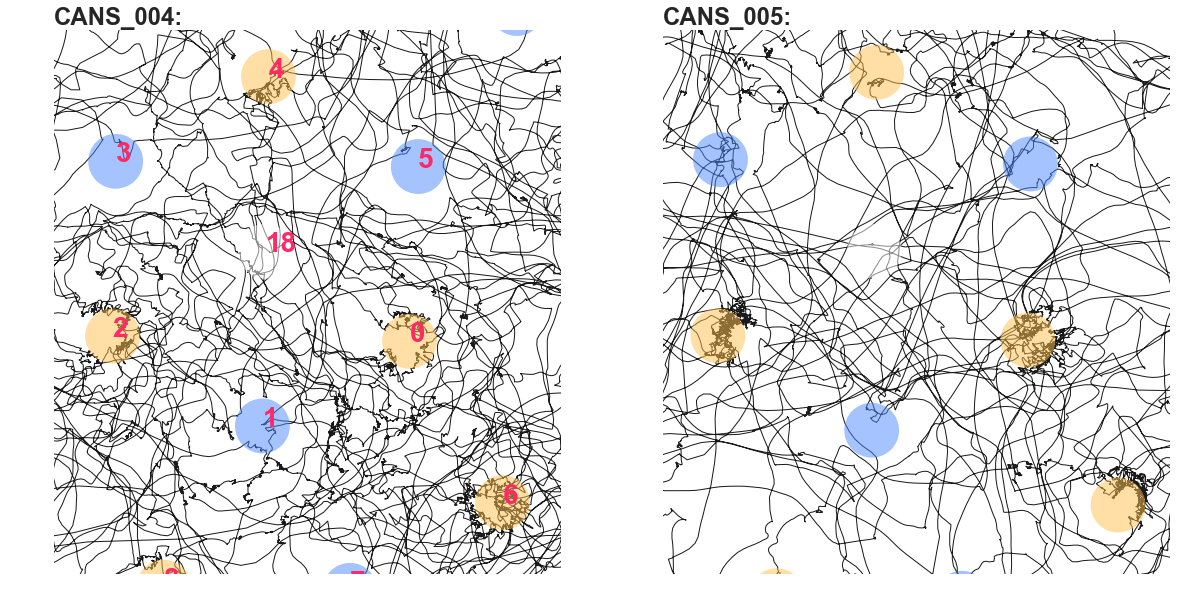

In [19]:
# plot zoomed 2d trajectory with color patches
fig, axes = plot_2d_patches_zoom(preview_data, 90)

<a id='section2.3'></a>
### C) Identifying the winner

In [20]:
# cut data down to 3 mins (180 s * 50 frames/s = 9000 frames)
chosen = 1
start = 56100
end = start + 9000
short_data = [preview_data[chosen].loc[start:end,:]]

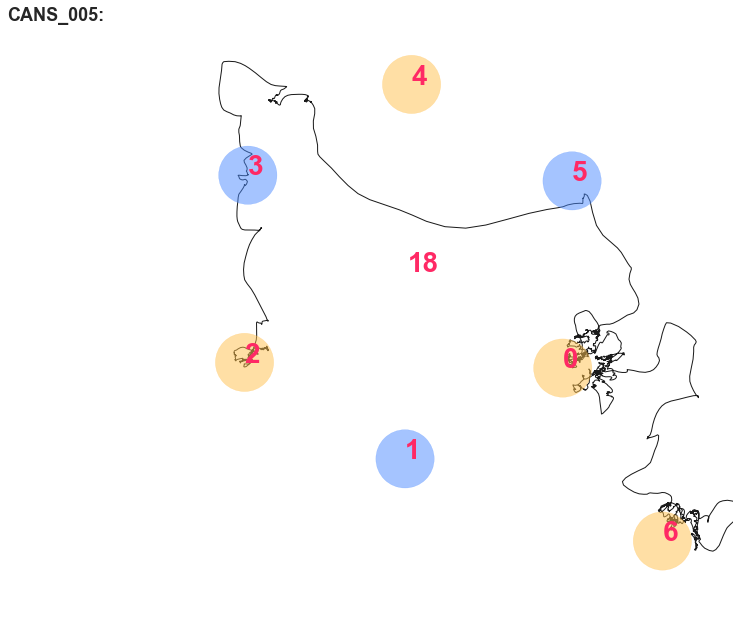

In [21]:
# plot zoomed 2d trajectory with color patches for given duration of time
fig, axes = plot_2d_patches_zoom(short_data, 90)
axes[0].set_title(possible_sessions[chosen]+":", fontweight='bold', loc='left', x=-0.3, y=1.05)

<a id='section3'></a>
## 3. Data Analysis

<a id='section3.1'></a>
### A) Loading raw data and meta data

In [22]:
# load session
this_session = db.session('CANS_005')
# load raw data and meta data
raw_data, meta_data = this_session.load()
# Start and end time (plotting for 1C & D only needed for that time window)
start = 56100
end = start + 9000
dt = 1/meta_data.framerate
#raw_data = raw_data.loc[start:end,:] # problems with Gaussian filtering (boundary value problems)

<a id='section3.2'></a>
### B) Preprocessing

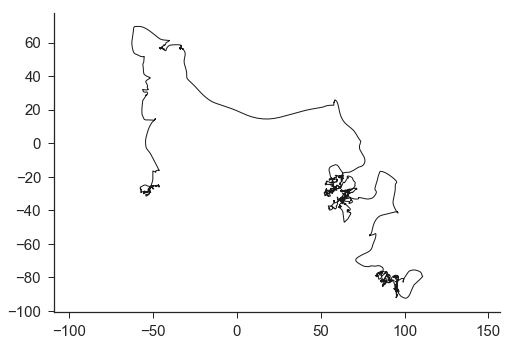

In [23]:
# plot zoomed 2d trajectory with color patches for given duration of time
plt.plot(raw_data.loc[start:end,'head_x'], raw_data.loc[start:end,'head_y'], 'k-', lw=1)
plt.axis("equal")
sns.despine()

In [24]:
## STEP 1: NaN removal + interpolation + px-to-mm conversion
clean_data = prep.interpolate(raw_data)
clean_data = prep.to_mm(clean_data, meta_data.px2mm)

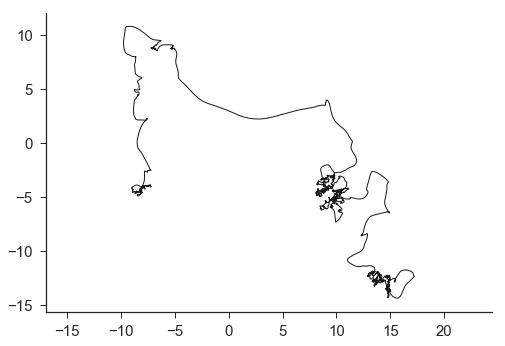

In [25]:
# plot zoomed 2d trajectory with color patches for given duration of time
plt.plot(clean_data.loc[start:end,'head_x'], clean_data.loc[start:end,'head_y'], 'k-', lw=1)
plt.axis("equal")
sns.despine()

In [26]:
## STEP 2: Gaussian filtering
window_len = 16 # = 0.32 s
smoothed_data = prep.gaussian_filter(clean_data, _len=window_len, _sigma=window_len/10)

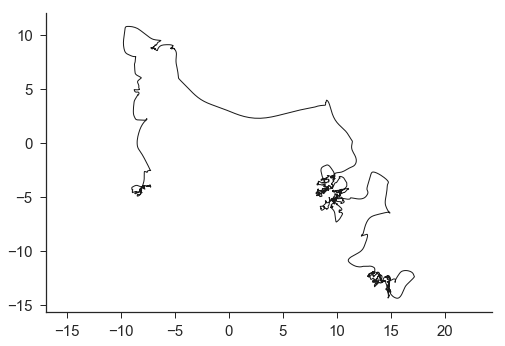

In [27]:
# plot zoomed 2d trajectory with color patches for given duration of time
plt.plot(smoothed_data.loc[start:end,'head_x'], smoothed_data.loc[start:end,'head_y'], 'k-', lw=1)
plt.axis("equal")
sns.despine()

<a id='section3.3'></a>
### C) Distance from patch

#### GOAL: 
> Recreating time series plot for distance to patch (patch 0) and line annotations of the distance thresholds (2.5 and 5 mm).

<img src="./img/ori-fig1ci.png" width="600" height="126">

In [28]:
## STEP 3: Distance from patch
kinematics = Kinematics(db)
distance_patch = kinematics.distance_to_patch(clean_data[['head_x', 'head_y']], meta_data)

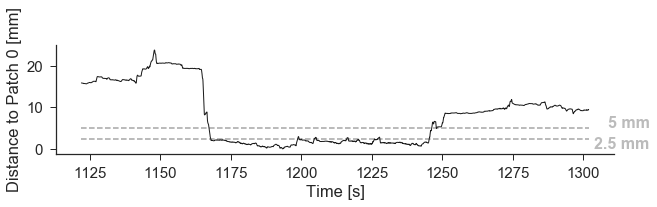

In [29]:
## arange time as a vector
time = np.arange(start*dt,(end+1)*dt,dt)
## new figure
plt.figure(figsize=(10,2))
## plotting data for distance to patch 0
plt.plot(time, distance_patch.loc[start:end,'dist_patch_0'], 'k-', lw=1)
## lines annotation
plt.hlines(5, time[0], time[-1], colors='#bbbbbb', linestyles='--', lw=2)
plt.hlines(2.5, time[0], time[-1], colors='#bbbbbb', linestyles='--', lw=2)
plt.text(time[-1]+7, 5, "5 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
plt.text(time[-1]+2, 0, "2.5 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
## axes labels
plt.xlabel("Time [s]")
plt.ylabel("Distance to Patch 0 [mm]")
## despined axes looks nicer
sns.despine()

Compared to the original plot, we seemed to have the same result. Note that the original plot has a broken y-axis with different scales, which we will add later on.

<img src="./img/ori-fig1ci.png" width="600" height="126">

<a id='section3.4'></a>
### D) Linear speeds

#### GOAL: 
> Recreating time series plot for body and head linear speeds and line annotations of the speed thresholds (0.2 mm and 2 mm).

<img src="./img/ori-fig1cii.jpg" width="600" height="125">

In [30]:
## STEP 4: Linear Speed
speed = kinematics.linear_speed(smoothed_data, meta_data)
window_len = 60 # = 1.2 s
smooth_speed = prep.gaussian_filter(speed, _len=window_len, _sigma=window_len/10)
window_len = 120 # = 1.2 s
smoother_speed = prep.gaussian_filter(smooth_speed, _len=window_len, _sigma=window_len/10)
speeds = pd.DataFrame({"head": smooth_speed["head_speed"], "body": smooth_speed["body_speed"], "smoother_head": smoother_speed["head_speed"]})
print(speeds.head(10))

        body       head  smoother_head
0  38.169300  38.720431      14.739530
1  39.711602  40.295509      15.410502
2  40.318857  40.924523      16.030726
3  39.986854  40.602786      16.593830
4  38.790352  39.405544      17.094458
5  36.872433  37.477275      17.528406
6  34.424957  35.012014      17.892713
7  31.663618  32.228232      18.185723
8  28.801891  29.342575      18.407105
9  26.027986  26.546628      18.557834


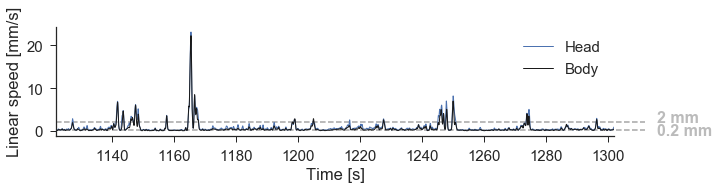

In [31]:
## new figure
plt.figure(figsize=(10,2))
## plotting data for head speeds as blue solid line
plt.plot(time, speeds.loc[start:end,'head'], 'b-', lw=1, label='Head')
## plotting data for body speeds as black solid line
plt.plot(time, speeds.loc[start:end,'body'], 'k-', lw=1, label='Body')
## add legend
plt.legend()
## lines annotation
plt.hlines(2, time[0], time[-1]+10, colors='#bbbbbb', linestyles='--', lw=2, clip_on=False)
plt.hlines(0.2, time[0], time[-1]+10, colors='#bbbbbb', linestyles='--', lw=2, clip_on=False)
plt.text(time[-1]+14, 2, "2 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
plt.text(time[-1]+14, -1, "0.2 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
## axes labels
plt.xlabel("Time [s]")
plt.ylabel("Linear speed [mm/s]")
plt.xlim([time[0],time[-1]])
#plt.ylim([0,20])
## despined axes looks nicer
sns.despine()

<img src="./img/ori-fig1cii.jpg" width="600" height="125">

<a id='section3.5'></a>
### E) Angular heading and speed

In [32]:
## STEP 5: Angular Heading & Speed
angular_heading = kinematics.head_angle(smoothed_data)
angular_speed = kinematics.angular_speed(angular_heading, meta_data)

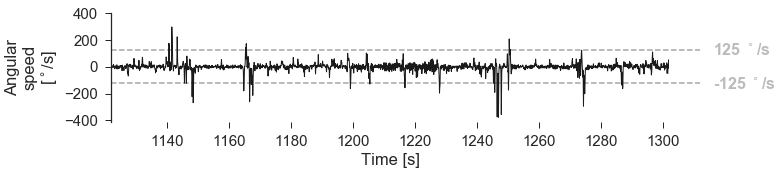

In [33]:
## new figure
plt.figure(figsize=(10,2))
## plotting data for angular speeds as black solid line
plt.plot(time, angular_speed.loc[start:end,:], 'k-', lw=1)
## lines annotation
plt.hlines(125, time[0], time[-1]+10, colors='#bbbbbb', linestyles='--', lw=2, clip_on=False)
plt.hlines(-125, time[0], time[-1]+10, colors='#bbbbbb', linestyles='--', lw=2, clip_on=False)
plt.text(time[-1]+14, 125-40, "125 $^\circ$/s", color='#bbbbbb', fontsize=16, fontweight='bold')
plt.text(time[-1]+14, -125-40, "-125 $^\circ$/s", color='#bbbbbb', fontsize=16, fontweight='bold')
## axes labels
plt.xlabel("Time [s]")
plt.ylabel("Angular\nspeed\n[$^\circ$/s]")
plt.xlim([time[0],time[-1]])
## despined axes looks nicer
plt.yticks(np.arange(-400, 401,200))
sns.despine(bottom=True)

<img src="./img/ori-fig1ciii.jpg" width="600" height="125">

<a id='section3.6'></a>
### F) Ethogram

In [51]:
## STEP 6: Ethogram classification
etho_dict = {   0: "resting",
                1: "micromovement",
                2: "walking",
                3: "sharp turn",
                4: "yeast micromovement",
                5: "sucrose micromovement"}
meta_data.dict["etho_class"] = etho_dict
etho_vector, visits = kinematics.ethogram(speeds, angular_speed, distance_patch, meta_data)
for frame, each in enumerate(etho_vector.loc[0:5,'etho']):
    print("Frame no. {}:\t".format(frame),int(each), "->", etho_dict[int(each)])

Frame no. 0:	 2 -> walking
Frame no. 1:	 2 -> walking
Frame no. 2:	 2 -> walking
Frame no. 3:	 2 -> walking
Frame no. 4:	 2 -> walking
Frame no. 5:	 2 -> walking


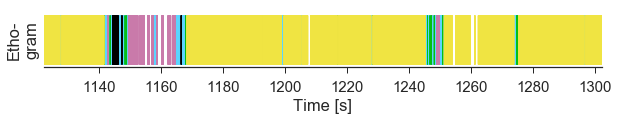

In [52]:
## new figure
plt.figure(figsize=(10,1))
## colors for ethogram
colors = ['#ffffff', '#c97aaa', '#5bd5ff', '#04bf11', '#f0e442', '#000000']
## plotting data for angular speeds as black solid line
data = np.array(etho_vector.loc[start:end,'etho'])
dy = 0.5
for ic, col in enumerate(colors):
    plt.vlines(time[data==ic],-dy,dy, colors=col, lw=0.5)

## axes labels
plt.xlabel("Time [s]")
plt.xlim([time[0],time[-1]])
## despined axes looks nicer & ethogram does not need y-axis
ax = plt.gca()
ax.get_yaxis().set_ticks([])
plt.ylabel("Etho-\ngram")
sns.despine(left=True)

<img src="./img/ori-fig1civ.png" width="600" height="125">

<a id='section3.7'></a>
### G) Visits

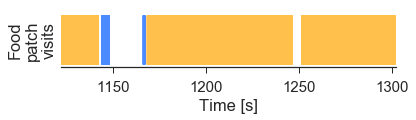

In [59]:
## new figure
plt.figure(figsize=(6,1))
## colors for ethogram
colors = ['#ffffff', '#ffc04c', '#4c8bff']
## plotting data for angular speeds as black solid line
data = np.array(visits.loc[start:end,'visits'])
dy = 0.5
for ic, col in enumerate(colors):
    plt.vlines(time[data==ic],-dy,dy, colors=col, lw=0.5)

## axes labels
plt.xlabel("Time [s]")
plt.xlim([time[0],time[-1]])
#plt.vlines(1143.52,-dy,dy, colors='#FF2965', linestyles='-', lw=0.5)
#plt.vlines(1147.74,-dy,dy, colors='#FF2965', linestyles='-', lw=0.5)
#plt.vlines(1165.72,-dy,dy, colors='#FF2965', linestyles='-', lw=0.5)
#plt.vlines(1166.98,-dy,dy, colors='#FF2965', linestyles='-', lw=0.5)
## despined axes looks nicer & ethogram does not need y-axis
ax = plt.gca()
ax.get_yaxis().set_ticks([])
plt.ylabel("Food\npatch\nvisits")
sns.despine(left=True)

<img src="./img/ori-fig1cv.jpg" width="600" height="125">

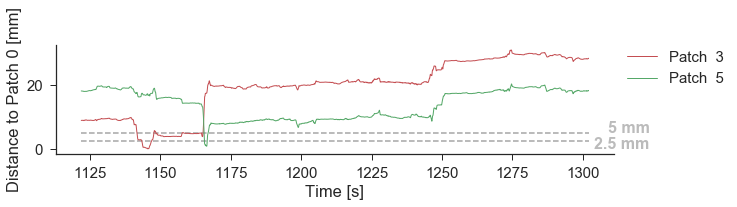

In [50]:
## new figure
f = plt.figure(figsize=(10,2))
## plotting data for distance to patch 3
plt.plot(time, distance_patch.loc[start:end,'dist_patch_3'], 'r-', lw=1, label='Patch  3')
## plotting data for distance to patch 5
plt.plot(time, distance_patch.loc[start:end,'dist_patch_5'], 'g-', lw=1, label='Patch  5')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
## lines annotation
plt.hlines(5, time[0], time[-1], colors='#bbbbbb', linestyles='--', lw=2)
plt.hlines(2.5, time[0], time[-1], colors='#bbbbbb', linestyles='--', lw=2)
plt.text(time[-1]+7, 5, "5 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
plt.text(time[-1]+2, 0, "2.5 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
## axes labels
plt.xlabel("Time [s]")
plt.ylabel("Distance to Patch 0 [mm]")
#plt.xlim([1140,1150])
## despined axes looks nicer
sns.despine()

In [38]:
## find out threshold passing for distance to patch 3
print("start of 3:", dt*distance_patch.loc[start:end].query("dist_patch_3<2.5").index.tolist()[0])
print("end of 3:", dt*distance_patch.loc[57176:end].query("dist_patch_3>5").index.tolist()[0])
## find out threshold passing for distance to patch 5
print("start of 5:", dt*distance_patch.loc[start:end].query("dist_patch_5<2.5").index.tolist()[0])
print("end of 5:", dt*distance_patch.loc[58286:end].query("dist_patch_5>5").index.tolist()[0])

start of 3: 1143.52
end of 3: 1147.74
start of 5: 1165.72
end of 5: 1166.98


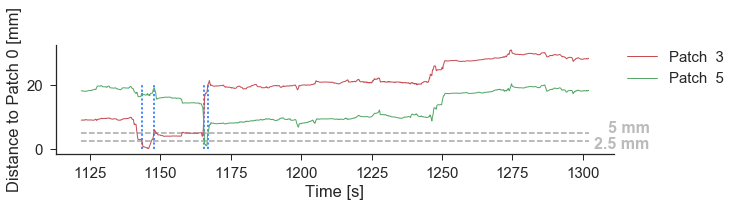

In [60]:
## new figure
f = plt.figure(figsize=(10,2))
## plotting data for distance to patch 3
plt.plot(time, distance_patch.loc[start:end,'dist_patch_3'], 'r-', lw=1, label='Patch  3')
## plotting data for distance to patch 5
plt.plot(time, distance_patch.loc[start:end,'dist_patch_5'], 'g-', lw=1, label='Patch  5')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
## lines annotation
plt.hlines(5, time[0], time[-1], colors='#bbbbbb', linestyles='--', lw=2)
plt.hlines(2.5, time[0], time[-1], colors='#bbbbbb', linestyles='--', lw=2)
plt.text(time[-1]+7, 5, "5 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
plt.text(time[-1]+2, 0, "2.5 mm", color='#bbbbbb', fontsize=16, fontweight='bold')
## vertical lines for visits
plt.vlines(1143.52, 0, 20, colors='#4c8bff', linestyles='dotted', lw=2)
plt.vlines(1147.74, 0, 20, colors='#4c8bff', linestyles='dotted', lw=2)
plt.vlines(1165.72, 0, 20, colors='#4c8bff', linestyles='dotted', lw=2)
plt.vlines(1166.98, 0, 20, colors='#4c8bff', linestyles='dotted', lw=2)
## axes labels
plt.xlabel("Time [s]")
plt.ylabel("Distance to Patch 0 [mm]")
#plt.xlim([1140,1170])
#plt.xticks(np.arange(1140,1171,5))
#plt.minorticks_on()
## despined axes looks nicer
sns.despine()

<a id='section3.8'></a>
### H) Loading ethogram data from multiple sessions

In [40]:
### Data for E-H
only_metab =  ["AA+ rich"]
only_gene = ["Canton S"]
group = db.experiment("CANS").select(genotype=only_gene, metabolic=only_metab)

### all session in that group
num_mated, num_virgins = db.experiment("CANS").count(only_gene, ['Mated', 'Virgin'], only_metab)
kinematics.print_header = True

etho_data = {}
for session in group:
    etho, visits = kinematics.run(session.name, _VERBOSE=True)
    etho_data[session.name] = etho['etho']
etho_data = pd.DataFrame(etho_data)
for i, metab in enumerate(only_metab):
    for gene in only_gene:
        print( "Analyzed {2} mated {0} females and {3} virgin {0} females [genotype: {1}]".format(metab, gene, int(num_mated[i]), int(num_virgins[i])) )

Analyzed 26 mated AA+ rich females and 15 virgin AA+ rich females [genotype: Canton S]


In [41]:
print(etho_data.tail(5))

        CANS_106  CANS_107  CANS_108  CANS_109  CANS_110  CANS_111  CANS_112  \
351065       2.0       2.0       2.0       2.0       2.0       2.0       2.0   
351066       2.0       2.0       2.0       2.0       2.0       2.0       2.0   
351067       2.0       2.0       2.0       2.0       2.0       2.0       2.0   
351068       2.0       2.0       2.0       2.0       2.0       2.0       2.0   
351069       2.0       2.0       2.0       2.0       2.0       2.0       2.0   

        CANS_113  CANS_114  CANS_115    ...     CANS_137  CANS_138  CANS_139  \
351065       2.0       2.0       2.0    ...          2.0       2.0       2.0   
351066       2.0       2.0       2.0    ...          2.0       2.0       2.0   
351067       2.0       2.0       2.0    ...          2.0       2.0       2.0   
351068       2.0       2.0       2.0    ...          2.0       2.0       2.0   
351069       2.0       2.0       2.0    ...          2.0       2.0       2.0   

        CANS_140  CANS_141  CANS_142  

<a id='section3.9'></a>
### I) Durations of behavioral segments

<a id='section4'></a>
## 4) Data visualization

<a id='section5'></a>
## 5) Closing remarks

In [42]:
# closing and printing out last logging
log.close()
log.show()


Last log entry:

2017-08-11 11:41:25,836 - Notebook Fig. 1 - INFO - ==================================================
2017-08-11 11:41:25,836 - Notebook Fig. 1 - INFO - ==================================================

